In [1]:
import torch
import numpy as np
import pandas as pd
import data
import tqdm
import autoencoder_resnet_simple
import models
from torchvision.transforms import v2

/home/anirudh/Documents/GSoC/DeepLense/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 32
EPOCHS = 100
LATENT_DIM = 512
LR = 5e-6
in_shape = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def transform():
    """
    Data augmentation by random rotation, and random scaling between 0.8 to 1.2

    :return: RandomAffine module that performs the transformation 
    """
    return v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))

In [3]:
train_dataset = data.LensingDataset('index.csv','../dataset/train/',transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [4]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        """
        Assembly of the autoencoder loaded with pretrained weights, the physics-informer and the classifier
        """
        super(Model, self).__init__()
        self.autoencoder = autoencoder_resnet_simple.AutoEncoder(dropout=0.1)
        self.autoencoder.load_state_dict(torch.load('autoencoder_simple_state_512.pt'))
        self.informer = models.LensAutoEncoder2(in_shape=in_shape,device=device)
        self.classifier = models.Resnet_simple()
    
    def forward(self, x):
        """
        Forward propagation

        :param x: Image to be classified
        :return: Predicted class
        """
        k = self.autoencoder(x)
        x = self.informer(k, x)
        x = self.classifier(x)
        return x

In [5]:
model = Model().to(device)

accs = []
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
best_val_loss = np.inf
best_weights = None
history = {'val_loss':[], 'loss':[], 'acc':[]}
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(loss))
        accs.append(float(acc))
    print("Training at epoch %d/%d: %.4f with acc=%.5f at LR=%.6f"%(epoch+1,EPOCHS,np.mean(losses),np.mean(accs),opt.param_groups[0]['lr']))
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    accs = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        label_indices = torch.argmax(y, 1)
        prediction_indices = torch.argmax(x, 1)
        acc = float(torch.sum(label_indices == prediction_indices))/float(len(label_indices))
        losses.append(float(val_loss))
        accs.append(float(acc))
    history['val_loss'].append(np.mean(losses))
    history['acc'].append(np.mean(accs))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} with acc={np.mean(accs)} at LR={opt.param_groups[0]['lr']}")


Training epoch 0: 100%|██████████| 844/844 [00:58<00:00, 14.39it/s]


Training at epoch 1/200: 1.1253 with acc=0.33986 at LR=0.000050


Validation epoch 0: 100%|██████████| 94/94 [00:04<00:00, 21.78it/s]


Validation at epoch 1/200: 1.105582687448948 with acc=0.33588209219858156 at LR=5e-05


Training epoch 1: 100%|██████████| 844/844 [00:56<00:00, 15.01it/s]


Training at epoch 2/200: 1.1114 with acc=0.33894 at LR=0.000050


Validation epoch 1: 100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


Validation at epoch 2/200: 1.1052602339298168 with acc=0.32668439716312053 at LR=5e-05


Training epoch 2: 100%|██████████| 844/844 [00:56<00:00, 15.01it/s]


Training at epoch 3/200: 1.1036 with acc=0.34355 at LR=0.000050


Validation epoch 2: 100%|██████████| 94/94 [00:04<00:00, 22.28it/s]


Validation at epoch 3/200: 1.0940114449947438 with acc=0.38242464539007087 at LR=5e-05


Training epoch 3: 100%|██████████| 844/844 [00:56<00:00, 15.07it/s]


Training at epoch 4/200: 1.0971 with acc=0.36305 at LR=0.000050


Validation epoch 3: 100%|██████████| 94/94 [00:04<00:00, 22.53it/s]


Validation at epoch 4/200: 1.0934834797331627 with acc=0.3682402482269504 at LR=5e-05


Training epoch 4: 100%|██████████| 844/844 [00:55<00:00, 15.10it/s]


Training at epoch 5/200: 1.0901 with acc=0.37105 at LR=0.000050


Validation epoch 4: 100%|██████████| 94/94 [00:04<00:00, 22.48it/s]


Validation at epoch 5/200: 1.0780358694969339 with acc=0.4058067375886525 at LR=5e-05


Training epoch 5: 100%|██████████| 844/844 [00:55<00:00, 15.13it/s]


Training at epoch 6/200: 1.0821 with acc=0.39132 at LR=0.000050


Validation epoch 5: 100%|██████████| 94/94 [00:04<00:00, 22.18it/s]


Validation at epoch 6/200: 1.0864409322434283 with acc=0.3949468085106383 at LR=5e-05


Training epoch 6: 100%|██████████| 844/844 [00:55<00:00, 15.21it/s]


Training at epoch 7/200: 1.0765 with acc=0.39852 at LR=0.000050


Validation epoch 6: 100%|██████████| 94/94 [00:04<00:00, 22.67it/s]


Validation at epoch 7/200: 1.08574326558316 with acc=0.3795434397163121 at LR=5e-05


Training epoch 7: 100%|██████████| 844/844 [00:55<00:00, 15.14it/s]


Training at epoch 8/200: 1.0704 with acc=0.40320 at LR=0.000050


Validation epoch 7: 100%|██████████| 94/94 [00:04<00:00, 22.62it/s]


Validation at epoch 8/200: 1.0624936286439286 with acc=0.4318484042553192 at LR=5e-05


Training epoch 8: 100%|██████████| 844/844 [00:55<00:00, 15.10it/s]


Training at epoch 9/200: 1.0673 with acc=0.41562 at LR=0.000050


Validation epoch 8: 100%|██████████| 94/94 [00:04<00:00, 22.37it/s]


Validation at epoch 9/200: 1.065042552161724 with acc=0.40591755319148937 at LR=5e-05


Training epoch 9: 100%|██████████| 844/844 [00:56<00:00, 15.03it/s]


Training at epoch 10/200: 1.0640 with acc=0.41493 at LR=0.000050


Validation epoch 9: 100%|██████████| 94/94 [00:04<00:00, 22.58it/s]


Validation at epoch 10/200: 1.0590311092265108 with acc=0.44437056737588654 at LR=5e-05


Training epoch 10: 100%|██████████| 844/844 [00:56<00:00, 15.00it/s]


Training at epoch 11/200: 1.0582 with acc=0.42771 at LR=0.000050


Validation epoch 10: 100%|██████████| 94/94 [00:04<00:00, 21.76it/s]


Validation at epoch 11/200: 1.0545998596130532 with acc=0.4397163120567376 at LR=5e-05


Training epoch 11: 100%|██████████| 844/844 [00:56<00:00, 15.03it/s]


Training at epoch 12/200: 1.0565 with acc=0.42924 at LR=0.000050


Validation epoch 11: 100%|██████████| 94/94 [00:04<00:00, 22.16it/s]


Validation at epoch 12/200: 1.0436515078899709 with acc=0.4557845744680851 at LR=5e-05


Training epoch 12: 100%|██████████| 844/844 [00:56<00:00, 15.05it/s]


Training at epoch 13/200: 1.0538 with acc=0.43622 at LR=0.000050


Validation epoch 12: 100%|██████████| 94/94 [00:04<00:00, 22.44it/s]


Validation at epoch 13/200: 1.0424158471695921 with acc=0.46287677304964536 at LR=5e-05


Training epoch 13: 100%|██████████| 844/844 [00:56<00:00, 15.03it/s]


Training at epoch 14/200: 1.0524 with acc=0.43750 at LR=0.000050


Validation epoch 13: 100%|██████████| 94/94 [00:04<00:00, 22.40it/s]


Validation at epoch 14/200: 1.0394560073284393 with acc=0.4726285460992908 at LR=5e-05


Training epoch 14: 100%|██████████| 844/844 [00:56<00:00, 14.97it/s]


Training at epoch 15/200: 1.0499 with acc=0.44365 at LR=0.000050


Validation epoch 14: 100%|██████████| 94/94 [00:04<00:00, 22.37it/s]


Validation at epoch 15/200: 1.0595832631943074 with acc=0.44359485815602834 at LR=5e-05


Training epoch 15: 100%|██████████| 844/844 [00:56<00:00, 15.02it/s]


Training at epoch 16/200: 1.0460 with acc=0.44739 at LR=0.000050


Validation epoch 15: 100%|██████████| 94/94 [00:04<00:00, 21.99it/s]


Validation at epoch 16/200: 1.0361143775442814 with acc=0.46520390070921985 at LR=5e-05


Training epoch 16: 100%|██████████| 844/844 [00:56<00:00, 14.99it/s]


Training at epoch 17/200: 1.0433 with acc=0.45536 at LR=0.000050


Validation epoch 16: 100%|██████████| 94/94 [00:04<00:00, 22.10it/s]


Validation at epoch 17/200: 1.0452977805695636 with acc=0.4299645390070922 at LR=5e-05


Training epoch 17: 100%|██████████| 844/844 [00:56<00:00, 15.00it/s]


Training at epoch 18/200: 1.0427 with acc=0.45153 at LR=0.000050


Validation epoch 17: 100%|██████████| 94/94 [00:04<00:00, 22.49it/s]


Validation at epoch 18/200: 1.0350875093581828 with acc=0.4819370567375887 at LR=5e-05


Training epoch 18: 100%|██████████| 844/844 [00:56<00:00, 15.05it/s]


Training at epoch 19/200: 1.0382 with acc=0.45963 at LR=0.000050


Validation epoch 18: 100%|██████████| 94/94 [00:04<00:00, 21.84it/s]


Validation at epoch 19/200: 1.0782368760159675 with acc=0.4048093971631206 at LR=5e-05


Training epoch 19: 100%|██████████| 844/844 [00:56<00:00, 15.01it/s]


Training at epoch 20/200: 1.0376 with acc=0.45253 at LR=0.000050


Validation epoch 19: 100%|██████████| 94/94 [00:04<00:00, 22.04it/s]


Validation at epoch 20/200: 1.0284049409501097 with acc=0.4762854609929078 at LR=5e-05


Training epoch 20: 100%|██████████| 844/844 [00:56<00:00, 14.94it/s]


Training at epoch 21/200: 1.0366 with acc=0.46224 at LR=0.000050


Validation epoch 20: 100%|██████████| 94/94 [00:04<00:00, 21.90it/s]


Validation at epoch 21/200: 1.0470724556040256 with acc=0.46841755319148937 at LR=5e-05


Training epoch 21: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 22/200: 1.0324 with acc=0.47077 at LR=0.000050


Validation epoch 21: 100%|██████████| 94/94 [00:04<00:00, 22.74it/s]


Validation at epoch 22/200: 1.0217103330378836 with acc=0.4852615248226951 at LR=5e-05


Training epoch 22: 100%|██████████| 844/844 [00:55<00:00, 15.13it/s]


Training at epoch 23/200: 1.0314 with acc=0.47142 at LR=0.000050


Validation epoch 22: 100%|██████████| 94/94 [00:04<00:00, 22.68it/s]


Validation at epoch 23/200: 1.050887442015587 with acc=0.45933067375886527 at LR=5e-05


Training epoch 23: 100%|██████████| 844/844 [00:55<00:00, 15.16it/s]


Training at epoch 24/200: 1.0297 with acc=0.47083 at LR=0.000050


Validation epoch 23: 100%|██████████| 94/94 [00:04<00:00, 22.46it/s]


Validation at epoch 24/200: 1.0295171674261703 with acc=0.47816932624113473 at LR=5e-05


Training epoch 24: 100%|██████████| 844/844 [00:55<00:00, 15.13it/s]


Training at epoch 25/200: 1.0268 with acc=0.48062 at LR=0.000050


Validation epoch 24: 100%|██████████| 94/94 [00:04<00:00, 22.32it/s]


Validation at epoch 25/200: 1.0226448254382356 with acc=0.4811613475177305 at LR=5e-05


Training epoch 25: 100%|██████████| 844/844 [00:55<00:00, 15.14it/s]


Training at epoch 26/200: 1.0266 with acc=0.47822 at LR=0.000050


Validation epoch 25: 100%|██████████| 94/94 [00:04<00:00, 22.30it/s]


Validation at epoch 26/200: 1.0287410299828712 with acc=0.49146719858156024 at LR=5e-05


Training epoch 26: 100%|██████████| 844/844 [00:56<00:00, 15.05it/s]


Training at epoch 27/200: 1.0223 with acc=0.48441 at LR=0.000050


Validation epoch 26: 100%|██████████| 94/94 [00:04<00:00, 22.45it/s]


Validation at epoch 27/200: 1.0138589574935588 with acc=0.4901374113475177 at LR=5e-05


Training epoch 27: 100%|██████████| 844/844 [00:55<00:00, 15.09it/s]


Training at epoch 28/200: 1.0228 with acc=0.48234 at LR=0.000050


Validation epoch 27: 100%|██████████| 94/94 [00:04<00:00, 22.67it/s]


Validation at epoch 28/200: 1.0180799682089623 with acc=0.4891400709219858 at LR=5e-05


Training epoch 28: 100%|██████████| 844/844 [00:55<00:00, 15.15it/s]


Training at epoch 29/200: 1.0205 with acc=0.48836 at LR=0.000050


Validation epoch 28: 100%|██████████| 94/94 [00:04<00:00, 22.24it/s]


Validation at epoch 29/200: 1.0046424364790003 with acc=0.5193927304964538 at LR=5e-05


Training epoch 29: 100%|██████████| 844/844 [00:56<00:00, 15.07it/s]


Training at epoch 30/200: 1.0179 with acc=0.49615 at LR=0.000050


Validation epoch 29: 100%|██████████| 94/94 [00:04<00:00, 22.14it/s]


Validation at epoch 30/200: 1.0484467446804047 with acc=0.4504654255319149 at LR=5e-05


Training epoch 30: 100%|██████████| 844/844 [00:55<00:00, 15.11it/s]


Training at epoch 31/200: 1.0171 with acc=0.48872 at LR=0.000050


Validation epoch 30: 100%|██████████| 94/94 [00:04<00:00, 22.70it/s]


Validation at epoch 31/200: 1.0446452625254368 with acc=0.4519060283687943 at LR=5e-05


Training epoch 31: 100%|██████████| 844/844 [00:55<00:00, 15.13it/s]


Training at epoch 32/200: 1.0160 with acc=0.48876 at LR=0.000050


Validation epoch 31: 100%|██████████| 94/94 [00:04<00:00, 22.41it/s]


Validation at epoch 32/200: 1.0198201156677085 with acc=0.4919104609929078 at LR=5e-05


Training epoch 32: 100%|██████████| 844/844 [00:55<00:00, 15.09it/s]


Training at epoch 33/200: 1.0136 with acc=0.49648 at LR=0.000050


Validation epoch 32: 100%|██████████| 94/94 [00:04<00:00, 22.70it/s]


Validation at epoch 33/200: 1.016111023882602 with acc=0.49589982269503546 at LR=5e-05


Training epoch 33: 100%|██████████| 844/844 [00:56<00:00, 15.06it/s]


Training at epoch 34/200: 1.0127 with acc=0.49635 at LR=0.000050


Validation epoch 33: 100%|██████████| 94/94 [00:04<00:00, 21.56it/s]


Validation at epoch 34/200: 1.017835848508997 with acc=0.5016622340425532 at LR=5e-05


Training epoch 34: 100%|██████████| 844/844 [00:55<00:00, 15.10it/s]


Training at epoch 35/200: 1.0091 with acc=0.50425 at LR=0.000050


Validation epoch 34: 100%|██████████| 94/94 [00:04<00:00, 22.28it/s]


Validation at epoch 35/200: 1.0323262994593763 with acc=0.478834219858156 at LR=5e-05


Training epoch 35: 100%|██████████| 844/844 [00:56<00:00, 15.07it/s]


Training at epoch 36/200: 1.0084 with acc=0.50223 at LR=0.000050


Validation epoch 35: 100%|██████████| 94/94 [00:04<00:00, 22.19it/s]


Validation at epoch 36/200: 1.0867289571051901 with acc=0.42819148936170215 at LR=5e-05


Training epoch 36: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 37/200: 1.0051 with acc=0.50501 at LR=0.000050


Validation epoch 36: 100%|██████████| 94/94 [00:04<00:00, 21.19it/s]


Validation at epoch 37/200: 1.033994346222979 with acc=0.4817154255319149 at LR=5e-05


Training epoch 37: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 38/200: 1.0015 with acc=0.51423 at LR=0.000050


Validation epoch 37: 100%|██████████| 94/94 [00:04<00:00, 21.90it/s]


Validation at epoch 38/200: 1.0521100055664143 with acc=0.46054964539007087 at LR=5e-05


Training epoch 38: 100%|██████████| 844/844 [00:57<00:00, 14.76it/s]


Training at epoch 39/200: 0.9967 with acc=0.51652 at LR=0.000050


Validation epoch 38: 100%|██████████| 94/94 [00:04<00:00, 20.08it/s]


Validation at epoch 39/200: 1.0137968748173816 with acc=0.506427304964539 at LR=5e-05


Training epoch 39: 100%|██████████| 844/844 [00:56<00:00, 14.93it/s]


Training at epoch 40/200: 1.0000 with acc=0.51748 at LR=0.000050


Validation epoch 39: 100%|██████████| 94/94 [00:04<00:00, 21.77it/s]


Validation at epoch 40/200: 1.0739224768699485 with acc=0.4484707446808511 at LR=5e-05


Training epoch 40: 100%|██████████| 844/844 [00:56<00:00, 14.95it/s]


Training at epoch 41/200: 0.9945 with acc=0.51806 at LR=0.000050


Validation epoch 40: 100%|██████████| 94/94 [00:04<00:00, 21.68it/s]


Validation at epoch 41/200: 1.0526260422899367 with acc=0.4619902482269504 at LR=5e-05


Training epoch 41: 100%|██████████| 844/844 [00:56<00:00, 14.97it/s]


Training at epoch 42/200: 0.9949 with acc=0.51938 at LR=0.000050


Validation epoch 41: 100%|██████████| 94/94 [00:04<00:00, 22.45it/s]


Validation at epoch 42/200: 1.0819789805310838 with acc=0.4372783687943262 at LR=5e-05


Training epoch 42: 100%|██████████| 844/844 [00:56<00:00, 14.96it/s]


Training at epoch 43/200: 0.9918 with acc=0.51891 at LR=0.000050


Validation epoch 42: 100%|██████████| 94/94 [00:04<00:00, 22.65it/s]


Validation at epoch 43/200: 1.0401932311818956 with acc=0.4752881205673759 at LR=5e-05


Training epoch 43: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 44/200: 0.9860 with acc=0.53044 at LR=0.000050


Validation epoch 43: 100%|██████████| 94/94 [00:04<00:00, 20.96it/s]


Validation at epoch 44/200: 1.0073049036746329 with acc=0.51739804964539 at LR=5e-05


Training epoch 44: 100%|██████████| 844/844 [00:57<00:00, 14.56it/s]


Training at epoch 45/200: 0.9851 with acc=0.53460 at LR=0.000050


Validation epoch 44: 100%|██████████| 94/94 [00:04<00:00, 20.80it/s]


Validation at epoch 45/200: 1.078109788133743 with acc=0.4493572695035461 at LR=5e-05


Training epoch 45: 100%|██████████| 844/844 [00:57<00:00, 14.67it/s]


Training at epoch 46/200: 0.9789 with acc=0.53513 at LR=0.000050


Validation epoch 45: 100%|██████████| 94/94 [00:04<00:00, 20.33it/s]


Validation at epoch 46/200: 1.0183191083847207 with acc=0.5115248226950355 at LR=5e-05


Training epoch 46: 100%|██████████| 844/844 [00:57<00:00, 14.57it/s]


Training at epoch 47/200: 0.9759 with acc=0.54257 at LR=0.000050


Validation epoch 46: 100%|██████████| 94/94 [00:04<00:00, 20.92it/s]


Validation at epoch 47/200: 1.0736332535743713 with acc=0.45378989361702127 at LR=5e-05


Training epoch 47: 100%|██████████| 844/844 [00:58<00:00, 14.54it/s]


Training at epoch 48/200: 0.9750 with acc=0.53945 at LR=0.000050


Validation epoch 47: 100%|██████████| 94/94 [00:04<00:00, 20.71it/s]


Validation at epoch 48/200: 1.0416536641881822 with acc=0.4852615248226951 at LR=5e-05


Training epoch 48: 100%|██████████| 844/844 [00:57<00:00, 14.68it/s]


Training at epoch 49/200: 0.9690 with acc=0.55030 at LR=0.000050


Validation epoch 48: 100%|██████████| 94/94 [00:04<00:00, 21.07it/s]


Validation at epoch 49/200: 1.0364946665916037 with acc=0.484375 at LR=5e-05


Training epoch 49: 100%|██████████| 844/844 [00:57<00:00, 14.68it/s]


Training at epoch 50/200: 0.9711 with acc=0.54954 at LR=0.000050


Validation epoch 49: 100%|██████████| 94/94 [00:04<00:00, 21.20it/s]


Validation at epoch 50/200: 1.1444051658853571 with acc=0.39904698581560283 at LR=5e-05


Training epoch 50: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 51/200: 0.9583 with acc=0.55083 at LR=0.000050


Validation epoch 50: 100%|██████████| 94/94 [00:04<00:00, 20.99it/s]


Validation at epoch 51/200: 1.0378058330809816 with acc=0.4930186170212766 at LR=5e-05


Training epoch 51: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 52/200: 0.9585 with acc=0.56156 at LR=0.000050


Validation epoch 51: 100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


Validation at epoch 52/200: 1.164689375999126 with acc=0.38120567375886527 at LR=5e-05


Training epoch 52: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 53/200: 0.9582 with acc=0.54941 at LR=0.000050


Validation epoch 52: 100%|██████████| 94/94 [00:04<00:00, 20.63it/s]


Validation at epoch 53/200: 1.0397235656038244 with acc=0.49501329787234044 at LR=5e-05


Training epoch 53: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 54/200: 0.9518 with acc=0.57096 at LR=0.000050


Validation epoch 53: 100%|██████████| 94/94 [00:04<00:00, 20.92it/s]


Validation at epoch 54/200: 1.0351088471869205 with acc=0.49745124113475175 at LR=5e-05


Training epoch 54: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 55/200: 0.9503 with acc=0.57011 at LR=0.000050


Validation epoch 54: 100%|██████████| 94/94 [00:04<00:00, 21.09it/s]


Validation at epoch 55/200: 1.0956488866755303 with acc=0.44148936170212766 at LR=5e-05


Training epoch 55: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 56/200: 0.9463 with acc=0.56976 at LR=0.000050


Validation epoch 55: 100%|██████████| 94/94 [00:04<00:00, 20.01it/s]


Validation at epoch 56/200: 1.0907414821868247 with acc=0.44891400709219853 at LR=5e-05


Training epoch 56: 100%|██████████| 844/844 [00:58<00:00, 14.55it/s]


Training at epoch 57/200: 0.9429 with acc=0.57188 at LR=0.000050


Validation epoch 56: 100%|██████████| 94/94 [00:04<00:00, 21.13it/s]


Validation at epoch 57/200: 0.9703424896331544 with acc=0.5575132978723404 at LR=5e-05


Training epoch 57: 100%|██████████| 844/844 [00:57<00:00, 14.77it/s]


Training at epoch 58/200: 0.9395 with acc=0.58799 at LR=0.000050


Validation epoch 57: 100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


Validation at epoch 58/200: 1.0356497327063947 with acc=0.498116134751773 at LR=5e-05


Training epoch 58: 100%|██████████| 844/844 [00:57<00:00, 14.75it/s]


Training at epoch 59/200: 0.9361 with acc=0.58538 at LR=0.000050


Validation epoch 58: 100%|██████████| 94/94 [00:04<00:00, 21.09it/s]


Validation at epoch 59/200: 1.025596261024475 with acc=0.5079787234042553 at LR=5e-05


Training epoch 59: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 60/200: 0.9382 with acc=0.58472 at LR=0.000050


Validation epoch 59: 100%|██████████| 94/94 [00:04<00:00, 20.99it/s]


Validation at epoch 60/200: 1.005587178341886 with acc=0.523936170212766 at LR=5e-05


Training epoch 60: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 61/200: 0.9320 with acc=0.59161 at LR=0.000050


Validation epoch 60: 100%|██████████| 94/94 [00:04<00:00, 20.99it/s]


Validation at epoch 61/200: 1.1041868341729997 with acc=0.43716755319148937 at LR=5e-05


Training epoch 61: 100%|██████████| 844/844 [00:57<00:00, 14.80it/s]


Training at epoch 62/200: 0.9298 with acc=0.58594 at LR=0.000050


Validation epoch 61: 100%|██████████| 94/94 [00:04<00:00, 21.12it/s]


Validation at epoch 62/200: 1.0381799923612716 with acc=0.49312943262411346 at LR=5e-05


Training epoch 62: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 63/200: 0.9265 with acc=0.59332 at LR=0.000050


Validation epoch 62: 100%|██████████| 94/94 [00:04<00:00, 21.25it/s]


Validation at epoch 63/200: 1.010803998150724 with acc=0.5242686170212766 at LR=5e-05


Training epoch 63: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 64/200: 0.9237 with acc=0.60078 at LR=0.000050


Validation epoch 63: 100%|██████████| 94/94 [00:04<00:00, 21.13it/s]


Validation at epoch 64/200: 1.0375745125273441 with acc=0.5006648936170213 at LR=5e-05


Training epoch 64: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 65/200: 0.9271 with acc=0.59486 at LR=0.000050


Validation epoch 64: 100%|██████████| 94/94 [00:04<00:00, 21.01it/s]


Validation at epoch 65/200: 0.9971716029846922 with acc=0.5370124113475178 at LR=5e-05


Training epoch 65: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 66/200: 0.9220 with acc=0.60283 at LR=0.000050


Validation epoch 65: 100%|██████████| 94/94 [00:04<00:00, 21.22it/s]


Validation at epoch 66/200: 1.116590570262138 with acc=0.4264184397163121 at LR=5e-05


Training epoch 66: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 67/200: 0.9229 with acc=0.59156 at LR=0.000050


Validation epoch 66: 100%|██████████| 94/94 [00:04<00:00, 21.31it/s]


Validation at epoch 67/200: 1.08960825775532 with acc=0.45246010638297873 at LR=5e-05


Training epoch 67: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 68/200: 0.9138 with acc=0.60338 at LR=0.000050


Validation epoch 67: 100%|██████████| 94/94 [00:04<00:00, 21.15it/s]


Validation at epoch 68/200: 0.9820045619568927 with acc=0.5483156028368794 at LR=5e-05


Training epoch 68: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 69/200: 0.9146 with acc=0.61238 at LR=0.000050


Validation epoch 68: 100%|██████████| 94/94 [00:04<00:00, 21.14it/s]


Validation at epoch 69/200: 1.0648791193962097 with acc=0.4773936170212766 at LR=5e-05


Training epoch 69: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 70/200: 0.9101 with acc=0.60808 at LR=0.000050


Validation epoch 69: 100%|██████████| 94/94 [00:04<00:00, 21.00it/s]


Validation at epoch 70/200: 1.0690330425475507 with acc=0.47229609929078015 at LR=5e-05


Training epoch 70: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 71/200: 0.9110 with acc=0.60590 at LR=0.000050


Validation epoch 70: 100%|██████████| 94/94 [00:04<00:00, 20.97it/s]


Validation at epoch 71/200: 1.0538468754037897 with acc=0.4872562056737589 at LR=5e-05


Training epoch 71: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 72/200: 0.9052 with acc=0.61398 at LR=0.000050


Validation epoch 71: 100%|██████████| 94/94 [00:04<00:00, 21.43it/s]


Validation at epoch 72/200: 1.0450543475911973 with acc=0.4966755319148936 at LR=5e-05


Training epoch 72: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 73/200: 0.9072 with acc=0.61472 at LR=0.000050


Validation epoch 72: 100%|██████████| 94/94 [00:04<00:00, 21.24it/s]


Validation at epoch 73/200: 1.0547535666759977 with acc=0.4864804964539007 at LR=5e-05


Training epoch 73: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 74/200: 0.9024 with acc=0.61844 at LR=0.000050


Validation epoch 73: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s]


Validation at epoch 74/200: 0.9702914763004222 with acc=0.563386524822695 at LR=5e-05


Training epoch 74: 100%|██████████| 844/844 [00:57<00:00, 14.75it/s]


Training at epoch 75/200: 0.9008 with acc=0.62741 at LR=0.000050


Validation epoch 74: 100%|██████████| 94/94 [00:04<00:00, 21.23it/s]


Validation at epoch 75/200: 1.014664871261475 with acc=0.5212765957446809 at LR=5e-05


Training epoch 75: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 76/200: 0.8976 with acc=0.62642 at LR=0.000050


Validation epoch 75: 100%|██████████| 94/94 [00:04<00:00, 20.90it/s]


Validation at epoch 76/200: 1.0246264966244394 with acc=0.5127437943262411 at LR=5e-05


Training epoch 76: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 77/200: 0.8968 with acc=0.62483 at LR=0.000050


Validation epoch 76: 100%|██████████| 94/94 [00:04<00:00, 21.21it/s]


Validation at epoch 77/200: 0.9548359151850355 with acc=0.5852171985815603 at LR=5e-05


Training epoch 77: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 78/200: 0.8978 with acc=0.63265 at LR=0.000050


Validation epoch 77: 100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


Validation at epoch 78/200: 1.066412292896433 with acc=0.47517730496453897 at LR=5e-05


Training epoch 78: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 79/200: 0.8960 with acc=0.62299 at LR=0.000050


Validation epoch 78: 100%|██████████| 94/94 [00:04<00:00, 21.20it/s]


Validation at epoch 79/200: 1.0111685331831588 with acc=0.5253767730496454 at LR=5e-05


Training epoch 79: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 80/200: 0.8925 with acc=0.63155 at LR=0.000050


Validation epoch 79: 100%|██████████| 94/94 [00:04<00:00, 21.10it/s]


Validation at epoch 80/200: 0.95188913890656 with acc=0.5824468085106383 at LR=5e-05


Training epoch 80: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 81/200: 0.8882 with acc=0.63989 at LR=0.000050


Validation epoch 80: 100%|██████████| 94/94 [00:04<00:00, 20.92it/s]


Validation at epoch 81/200: 0.9443340840491843 with acc=0.5924202127659575 at LR=5e-05


Training epoch 81: 100%|██████████| 844/844 [00:57<00:00, 14.69it/s]


Training at epoch 82/200: 0.8883 with acc=0.64360 at LR=0.000050


Validation epoch 81: 100%|██████████| 94/94 [00:04<00:00, 21.08it/s]


Validation at epoch 82/200: 0.9227252069939959 with acc=0.6165780141843972 at LR=5e-05


Training epoch 82: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 83/200: 0.8875 with acc=0.64566 at LR=0.000050


Validation epoch 82: 100%|██████████| 94/94 [00:04<00:00, 21.15it/s]


Validation at epoch 83/200: 0.9164600023563872 with acc=0.6256648936170213 at LR=5e-05


Training epoch 83: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 84/200: 0.8896 with acc=0.64358 at LR=0.000050


Validation epoch 83: 100%|██████████| 94/94 [00:04<00:00, 21.26it/s]


Validation at epoch 84/200: 1.0667085558810132 with acc=0.47828014184397166 at LR=5e-05


Training epoch 84: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 85/200: 0.8880 with acc=0.63113 at LR=0.000050


Validation epoch 84: 100%|██████████| 94/94 [00:04<00:00, 21.17it/s]


Validation at epoch 85/200: 1.0121700338860775 with acc=0.526595744680851 at LR=5e-05


Training epoch 85: 100%|██████████| 844/844 [00:57<00:00, 14.69it/s]


Training at epoch 86/200: 0.8826 with acc=0.64082 at LR=0.000050


Validation epoch 85: 100%|██████████| 94/94 [00:04<00:00, 21.05it/s]


Validation at epoch 86/200: 0.906027154085484 with acc=0.6326462765957447 at LR=5e-05


Training epoch 86: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 87/200: 0.8834 with acc=0.65202 at LR=0.000050


Validation epoch 86: 100%|██████████| 94/94 [00:04<00:00, 20.84it/s]


Validation at epoch 87/200: 1.0267247779572264 with acc=0.5131870567375887 at LR=5e-05


Training epoch 87: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 88/200: 0.8745 with acc=0.64769 at LR=0.000050


Validation epoch 87: 100%|██████████| 94/94 [00:04<00:00, 21.07it/s]


Validation at epoch 88/200: 0.8972241257099395 with acc=0.6384086879432623 at LR=5e-05


Training epoch 88: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 89/200: 0.8777 with acc=0.65613 at LR=0.000050


Validation epoch 88: 100%|██████████| 94/94 [00:04<00:00, 21.09it/s]


Validation at epoch 89/200: 1.03871895341163 with acc=0.5058732269503546 at LR=5e-05


Training epoch 89: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 90/200: 0.8750 with acc=0.64682 at LR=0.000050


Validation epoch 89: 100%|██████████| 94/94 [00:04<00:00, 21.22it/s]


Validation at epoch 90/200: 0.8970226062105057 with acc=0.6427304964539007 at LR=5e-05


Training epoch 90: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 91/200: 0.8733 with acc=0.66196 at LR=0.000050


Validation epoch 90: 100%|██████████| 94/94 [00:04<00:00, 21.19it/s]


Validation at epoch 91/200: 0.9498519117527819 with acc=0.5897606382978723 at LR=5e-05


Training epoch 91: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 92/200: 0.8724 with acc=0.65777 at LR=0.000050


Validation epoch 91: 100%|██████████| 94/94 [00:04<00:00, 21.08it/s]


Validation at epoch 92/200: 0.9711998200162928 with acc=0.5688164893617021 at LR=5e-05


Training epoch 92: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 93/200: 0.8700 with acc=0.65850 at LR=0.000050


Validation epoch 92: 100%|██████████| 94/94 [00:04<00:00, 20.93it/s]


Validation at epoch 93/200: 0.9702063234562569 with acc=0.5702570921985816 at LR=5e-05


Training epoch 93: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 94/200: 0.8681 with acc=0.65980 at LR=0.000050


Validation epoch 93: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s]


Validation at epoch 94/200: 0.9709499586135784 with acc=0.571697695035461 at LR=5e-05


Training epoch 94: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 95/200: 0.8701 with acc=0.65793 at LR=0.000050


Validation epoch 94: 100%|██████████| 94/94 [00:04<00:00, 21.16it/s]


Validation at epoch 95/200: 0.9594585667265222 with acc=0.579011524822695 at LR=5e-05


Training epoch 95: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 96/200: 0.8668 with acc=0.66083 at LR=0.000050


Validation epoch 95: 100%|██████████| 94/94 [00:04<00:00, 21.15it/s]


Validation at epoch 96/200: 0.9468698400132199 with acc=0.5899822695035462 at LR=5e-05


Training epoch 96: 100%|██████████| 844/844 [00:57<00:00, 14.61it/s]


Training at epoch 97/200: 0.8632 with acc=0.66503 at LR=0.000050


Validation epoch 96: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s]


Validation at epoch 97/200: 0.9903737737777385 with acc=0.5494237588652483 at LR=5e-05


Training epoch 97: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 98/200: 0.8622 with acc=0.66227 at LR=0.000050


Validation epoch 97: 100%|██████████| 94/94 [00:04<00:00, 20.69it/s]


Validation at epoch 98/200: 0.9285942683828637 with acc=0.610261524822695 at LR=5e-05


Training epoch 98: 100%|██████████| 844/844 [00:57<00:00, 14.75it/s]


Training at epoch 99/200: 0.8646 with acc=0.66652 at LR=0.000050


Validation epoch 98: 100%|██████████| 94/94 [00:04<00:00, 20.74it/s]


Validation at epoch 99/200: 0.9694771582775927 with acc=0.5694813829787234 at LR=5e-05


Training epoch 99: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 100/200: 0.8589 with acc=0.66869 at LR=0.000050


Validation epoch 99: 100%|██████████| 94/94 [00:04<00:00, 20.77it/s]


Validation at epoch 100/200: 0.91634098456261 with acc=0.6256648936170213 at LR=5e-05


Training epoch 100: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 101/200: 0.8632 with acc=0.67091 at LR=0.000050


Validation epoch 100: 100%|██████████| 94/94 [00:04<00:00, 20.96it/s]


Validation at epoch 101/200: 0.9194399917379339 with acc=0.6225620567375887 at LR=5e-05


Training epoch 101: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 102/200: 0.8602 with acc=0.67355 at LR=0.000050


Validation epoch 101: 100%|██████████| 94/94 [00:04<00:00, 21.06it/s]


Validation at epoch 102/200: 0.989780918714848 with acc=0.5520833333333334 at LR=5e-05


Training epoch 102: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 103/200: 0.8552 with acc=0.67072 at LR=0.000050


Validation epoch 102: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s]


Validation at epoch 103/200: 0.8794701118418511 with acc=0.6563608156028369 at LR=5e-05


Training epoch 103: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 104/200: 0.8547 with acc=0.68089 at LR=0.000050


Validation epoch 103: 100%|██████████| 94/94 [00:04<00:00, 21.09it/s]


Validation at epoch 104/200: 0.9164442166369012 with acc=0.6248891843971631 at LR=5e-05


Training epoch 104: 100%|██████████| 844/844 [00:57<00:00, 14.74it/s]


Training at epoch 105/200: 0.8564 with acc=0.67721 at LR=0.000050


Validation epoch 104: 100%|██████████| 94/94 [00:04<00:00, 21.11it/s]


Validation at epoch 105/200: 0.916753944564373 with acc=0.6223404255319149 at LR=5e-05


Training epoch 105: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 106/200: 0.8505 with acc=0.68220 at LR=0.000050


Validation epoch 105: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s]


Validation at epoch 106/200: 0.9521832301261577 with acc=0.5889849290780143 at LR=5e-05


Training epoch 106: 100%|██████████| 844/844 [00:57<00:00, 14.72it/s]


Training at epoch 107/200: 0.8544 with acc=0.67518 at LR=0.000050


Validation epoch 106: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s]


Validation at epoch 107/200: 0.9792243793923804 with acc=0.5626108156028369 at LR=5e-05


Training epoch 107: 100%|██████████| 844/844 [00:57<00:00, 14.71it/s]


Training at epoch 108/200: 0.8501 with acc=0.67571 at LR=0.000050


Validation epoch 107: 100%|██████████| 94/94 [00:04<00:00, 21.09it/s]


Validation at epoch 108/200: 0.979801983909404 with acc=0.5619459219858156 at LR=5e-05


Training epoch 108: 100%|██████████| 844/844 [00:57<00:00, 14.73it/s]


Training at epoch 109/200: 0.8496 with acc=0.67768 at LR=0.000050


Validation epoch 108: 100%|██████████| 94/94 [00:04<00:00, 20.48it/s]


Validation at epoch 109/200: 0.8855266158885144 with acc=0.6558067375886525 at LR=5e-05


Training epoch 109: 100%|██████████| 844/844 [00:57<00:00, 14.70it/s]


Training at epoch 110/200: 0.8452 with acc=0.69080 at LR=0.000050


Validation epoch 109: 100%|██████████| 94/94 [00:04<00:00, 20.30it/s]


Validation at epoch 110/200: 0.9751192895655937 with acc=0.5641622340425532 at LR=5e-05


Training epoch 110: 100%|██████████| 844/844 [00:57<00:00, 14.67it/s]


Training at epoch 111/200: 0.8462 with acc=0.68090 at LR=0.000050


Validation epoch 110: 100%|██████████| 94/94 [00:04<00:00, 20.56it/s]


Validation at epoch 111/200: 0.86912524763574 with acc=0.6707668439716312 at LR=5e-05


Training epoch 111: 100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Training at epoch 112/200: 0.8471 with acc=0.68894 at LR=0.000050


Validation epoch 111: 100%|██████████| 94/94 [00:04<00:00, 20.33it/s]


Validation at epoch 112/200: 0.924565981677238 with acc=0.6174645390070922 at LR=5e-05


Training epoch 112: 100%|██████████| 844/844 [00:57<00:00, 14.65it/s]


Training at epoch 113/200: 0.8463 with acc=0.68527 at LR=0.000050


Validation epoch 112: 100%|██████████| 94/94 [00:04<00:00, 20.66it/s]


Validation at epoch 113/200: 1.03650353627002 with acc=0.5076462765957447 at LR=5e-05


Training epoch 113: 100%|██████████| 844/844 [00:57<00:00, 14.69it/s]


Training at epoch 114/200: 0.8437 with acc=0.67897 at LR=0.000050


Validation epoch 113: 100%|██████████| 94/94 [00:04<00:00, 20.23it/s]


Validation at epoch 114/200: 0.8990603387355804 with acc=0.6410682624113475 at LR=5e-05


Training epoch 114: 100%|██████████| 844/844 [00:57<00:00, 14.68it/s]


Training at epoch 115/200: 0.8420 with acc=0.69355 at LR=0.000050


Validation epoch 114: 100%|██████████| 94/94 [00:04<00:00, 20.53it/s]


Validation at epoch 115/200: 0.9679601534884027 with acc=0.5748005319148937 at LR=5e-05


Training epoch 115: 100%|██████████| 844/844 [00:57<00:00, 14.68it/s]


Training at epoch 116/200: 0.8417 with acc=0.68503 at LR=0.000050


Validation epoch 115: 100%|██████████| 94/94 [00:04<00:00, 20.25it/s]


Validation at epoch 116/200: 0.9408319738317044 with acc=0.6017287234042553 at LR=5e-05


Training epoch 116: 100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Training at epoch 117/200: 0.8362 with acc=0.69372 at LR=0.000050


Validation epoch 116: 100%|██████████| 94/94 [00:04<00:00, 20.16it/s]


Validation at epoch 117/200: 0.934183896856105 with acc=0.6089317375886525 at LR=5e-05


Training epoch 117: 100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Training at epoch 118/200: 0.8413 with acc=0.68918 at LR=0.000050


Validation epoch 117: 100%|██████████| 94/94 [00:04<00:00, 20.14it/s]


Validation at epoch 118/200: 0.9841534057830242 with acc=0.5611702127659575 at LR=5e-05


Training epoch 118: 100%|██████████| 844/844 [00:57<00:00, 14.67it/s]


Training at epoch 119/200: 0.8410 with acc=0.68611 at LR=0.000050


Validation epoch 118: 100%|██████████| 94/94 [00:04<00:00, 20.33it/s]


Validation at epoch 119/200: 0.8980249350375318 with acc=0.640625 at LR=5e-05


Training epoch 119: 100%|██████████| 844/844 [00:57<00:00, 14.63it/s]


Training at epoch 120/200: 0.8404 with acc=0.69406 at LR=0.000050


Validation epoch 119: 100%|██████████| 94/94 [00:04<00:00, 19.69it/s]


Validation at epoch 120/200: 0.9400538301214258 with acc=0.6016179078014184 at LR=5e-05


Training epoch 120: 100%|██████████| 844/844 [00:57<00:00, 14.59it/s]


Training at epoch 121/200: 0.8400 with acc=0.68907 at LR=0.000050


Validation epoch 120: 100%|██████████| 94/94 [00:04<00:00, 20.15it/s]


Validation at epoch 121/200: 0.9201782561363058 with acc=0.6212322695035462 at LR=5e-05


Training epoch 121: 100%|██████████| 844/844 [00:57<00:00, 14.75it/s]


Training at epoch 122/200: 0.8346 with acc=0.69686 at LR=0.000050


Validation epoch 121: 100%|██████████| 94/94 [00:04<00:00, 20.92it/s]


Validation at epoch 122/200: 0.952200452698038 with acc=0.5885416666666666 at LR=5e-05


Training epoch 122: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 123/200: 0.8335 with acc=0.69426 at LR=0.000050


Validation epoch 122: 100%|██████████| 94/94 [00:04<00:00, 21.26it/s]


Validation at epoch 123/200: 0.9494143026940366 with acc=0.5956338652482269 at LR=5e-05


Training epoch 123: 100%|██████████| 844/844 [00:56<00:00, 14.86it/s]


Training at epoch 124/200: 0.8306 with acc=0.69926 at LR=0.000050


Validation epoch 123: 100%|██████████| 94/94 [00:04<00:00, 20.99it/s]


Validation at epoch 124/200: 0.9094517478283416 with acc=0.6307624113475178 at LR=5e-05


Training epoch 124: 100%|██████████| 844/844 [00:56<00:00, 14.86it/s]


Training at epoch 125/200: 0.8285 with acc=0.70449 at LR=0.000050


Validation epoch 124: 100%|██████████| 94/94 [00:04<00:00, 20.99it/s]


Validation at epoch 125/200: 0.8737697499863645 with acc=0.666334219858156 at LR=5e-05


Training epoch 125: 100%|██████████| 844/844 [00:56<00:00, 14.85it/s]


Training at epoch 126/200: 0.8321 with acc=0.70519 at LR=0.000050


Validation epoch 125: 100%|██████████| 94/94 [00:04<00:00, 21.75it/s]


Validation at epoch 126/200: 0.9496996472490594 with acc=0.5933067375886525 at LR=5e-05


Training epoch 126: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 127/200: 0.8290 with acc=0.70144 at LR=0.000050


Validation epoch 126: 100%|██████████| 94/94 [00:04<00:00, 22.06it/s]


Validation at epoch 127/200: 0.9127582990108652 with acc=0.6278812056737589 at LR=5e-05


Training epoch 127: 100%|██████████| 844/844 [00:56<00:00, 14.93it/s]


Training at epoch 128/200: 0.8307 with acc=0.70245 at LR=0.000050


Validation epoch 127: 100%|██████████| 94/94 [00:04<00:00, 21.59it/s]


Validation at epoch 128/200: 0.9339029801652786 with acc=0.6080452127659575 at LR=5e-05


Training epoch 128: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 129/200: 0.8273 with acc=0.70315 at LR=0.000050


Validation epoch 128: 100%|██████████| 94/94 [00:04<00:00, 21.68it/s]


Validation at epoch 129/200: 0.8315609420867677 with acc=0.710438829787234 at LR=5e-05


Training epoch 129: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 130/200: 0.8255 with acc=0.71454 at LR=0.000050


Validation epoch 129: 100%|██████████| 94/94 [00:04<00:00, 21.53it/s]


Validation at epoch 130/200: 0.9242483859366559 with acc=0.6186835106382979 at LR=5e-05


Training epoch 130: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 131/200: 0.8269 with acc=0.70344 at LR=0.000050


Validation epoch 130: 100%|██████████| 94/94 [00:04<00:00, 21.44it/s]


Validation at epoch 131/200: 0.9684201643822041 with acc=0.5752437943262411 at LR=5e-05


Training epoch 131: 100%|██████████| 844/844 [00:56<00:00, 14.91it/s]


Training at epoch 132/200: 0.8206 with acc=0.70587 at LR=0.000050


Validation epoch 131: 100%|██████████| 94/94 [00:04<00:00, 21.65it/s]


Validation at epoch 132/200: 0.9317863868906143 with acc=0.6124778368794326 at LR=5e-05


Training epoch 132: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 133/200: 0.8259 with acc=0.70319 at LR=0.000050


Validation epoch 132: 100%|██████████| 94/94 [00:04<00:00, 21.66it/s]


Validation at epoch 133/200: 0.8835207141460256 with acc=0.6559175531914894 at LR=5e-05


Training epoch 133: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 134/200: 0.8269 with acc=0.70819 at LR=0.000050


Validation epoch 133: 100%|██████████| 94/94 [00:04<00:00, 21.46it/s]


Validation at epoch 134/200: 0.8901628668003894 with acc=0.6559175531914894 at LR=5e-05


Training epoch 134: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 135/200: 0.8209 with acc=0.71419 at LR=0.000050


Validation epoch 134: 100%|██████████| 94/94 [00:04<00:00, 21.79it/s]


Validation at epoch 135/200: 0.9050663297480726 with acc=0.6361923758865249 at LR=5e-05


Training epoch 135: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 136/200: 0.8216 with acc=0.71183 at LR=0.000050


Validation epoch 135: 100%|██████████| 94/94 [00:04<00:00, 21.88it/s]


Validation at epoch 136/200: 0.8825255626059593 with acc=0.6574689716312057 at LR=5e-05


Training epoch 136: 100%|██████████| 844/844 [00:56<00:00, 14.93it/s]


Training at epoch 137/200: 0.8210 with acc=0.71331 at LR=0.000050


Validation epoch 136: 100%|██████████| 94/94 [00:04<00:00, 21.66it/s]


Validation at epoch 137/200: 0.9731730089542714 with acc=0.5688164893617021 at LR=5e-05


Training epoch 137: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 138/200: 0.8211 with acc=0.70517 at LR=0.000050


Validation epoch 137: 100%|██████████| 94/94 [00:04<00:00, 21.53it/s]


Validation at epoch 138/200: 1.0200209395682558 with acc=0.526595744680851 at LR=5e-05


Training epoch 138: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 139/200: 0.8214 with acc=0.70114 at LR=0.000050


Validation epoch 138: 100%|██████████| 94/94 [00:04<00:00, 21.81it/s]


Validation at epoch 139/200: 0.8538313894829852 with acc=0.6892730496453902 at LR=5e-05


Training epoch 139: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 140/200: 0.8148 with acc=0.72419 at LR=0.000050


Validation epoch 139: 100%|██████████| 94/94 [00:04<00:00, 21.67it/s]


Validation at epoch 140/200: 0.9390510105072184 with acc=0.6058289007092198 at LR=5e-05


Training epoch 140: 100%|██████████| 844/844 [00:56<00:00, 14.94it/s]


Training at epoch 141/200: 0.8163 with acc=0.71387 at LR=0.000050


Validation epoch 140: 100%|██████████| 94/94 [00:04<00:00, 21.64it/s]


Validation at epoch 141/200: 0.9608471019470946 with acc=0.5842198581560284 at LR=5e-05


Training epoch 141: 100%|██████████| 844/844 [00:56<00:00, 14.87it/s]


Training at epoch 142/200: 0.8179 with acc=0.71038 at LR=0.000050


Validation epoch 141: 100%|██████████| 94/94 [00:04<00:00, 21.61it/s]


Validation at epoch 142/200: 0.8956364691257477 with acc=0.6483820921985816 at LR=5e-05


Training epoch 142: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 143/200: 0.8131 with acc=0.72153 at LR=0.000050


Validation epoch 142: 100%|██████████| 94/94 [00:04<00:00, 21.55it/s]


Validation at epoch 143/200: 0.8771537662820613 with acc=0.6685505319148937 at LR=5e-05


Training epoch 143: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 144/200: 0.8158 with acc=0.72027 at LR=0.000050


Validation epoch 143: 100%|██████████| 94/94 [00:04<00:00, 21.68it/s]


Validation at epoch 144/200: 0.879928098714098 with acc=0.6607934397163121 at LR=5e-05


Training epoch 144: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 145/200: 0.8126 with acc=0.72229 at LR=0.000050


Validation epoch 144: 100%|██████████| 94/94 [00:04<00:00, 21.70it/s]


Validation at epoch 145/200: 0.8764140377653405 with acc=0.6662234042553191 at LR=5e-05


Training epoch 145: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 146/200: 0.8086 with acc=0.72675 at LR=0.000050


Validation epoch 145: 100%|██████████| 94/94 [00:04<00:00, 21.81it/s]


Validation at epoch 146/200: 0.8651600004510677 with acc=0.6800753546099291 at LR=5e-05


Training epoch 146: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 147/200: 0.8085 with acc=0.72883 at LR=0.000050


Validation epoch 146: 100%|██████████| 94/94 [00:04<00:00, 21.72it/s]


Validation at epoch 147/200: 0.9051827255715715 with acc=0.63885195035461 at LR=5e-05


Training epoch 147: 100%|██████████| 844/844 [00:56<00:00, 14.87it/s]


Training at epoch 148/200: 0.8082 with acc=0.72454 at LR=0.000050


Validation epoch 147: 100%|██████████| 94/94 [00:04<00:00, 21.39it/s]


Validation at epoch 148/200: 0.8597655188530049 with acc=0.679188829787234 at LR=5e-05


Training epoch 148: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 149/200: 0.8095 with acc=0.72708 at LR=0.000050


Validation epoch 148: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


Validation at epoch 149/200: 0.903789444172636 with acc=0.6400709219858156 at LR=5e-05


Training epoch 149: 100%|██████████| 844/844 [00:56<00:00, 14.91it/s]


Training at epoch 150/200: 0.8079 with acc=0.72367 at LR=0.000050


Validation epoch 149: 100%|██████████| 94/94 [00:04<00:00, 21.73it/s]


Validation at epoch 150/200: 0.8633085210272606 with acc=0.679188829787234 at LR=5e-05


Training epoch 150: 100%|██████████| 844/844 [00:56<00:00, 14.92it/s]


Training at epoch 151/200: 0.8099 with acc=0.72761 at LR=0.000050


Validation epoch 150: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s]


Validation at epoch 151/200: 0.9697264394861587 with acc=0.5746897163120568 at LR=5e-05


Training epoch 151: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 152/200: 0.8046 with acc=0.72206 at LR=0.000050


Validation epoch 151: 100%|██████████| 94/94 [00:04<00:00, 21.59it/s]


Validation at epoch 152/200: 0.8505732975107558 with acc=0.6906028368794327 at LR=5e-05


Training epoch 152: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 153/200: 0.8053 with acc=0.73265 at LR=0.000050


Validation epoch 152: 100%|██████████| 94/94 [00:04<00:00, 21.34it/s]


Validation at epoch 153/200: 0.806469958513341 with acc=0.7372562056737588 at LR=5e-05


Training epoch 153: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 154/200: 0.8053 with acc=0.73687 at LR=0.000050


Validation epoch 153: 100%|██████████| 94/94 [00:04<00:00, 21.65it/s]


Validation at epoch 154/200: 0.9093037805658706 with acc=0.635195035460993 at LR=5e-05


Training epoch 154: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 155/200: 0.8015 with acc=0.73189 at LR=0.000050


Validation epoch 154: 100%|██████████| 94/94 [00:04<00:00, 21.59it/s]


Validation at epoch 155/200: 0.8971763963394976 with acc=0.6472739361702128 at LR=5e-05


Training epoch 155: 100%|██████████| 844/844 [00:56<00:00, 14.89it/s]


Training at epoch 156/200: 0.8048 with acc=0.72886 at LR=0.000050


Validation epoch 155: 100%|██████████| 94/94 [00:04<00:00, 21.58it/s]


Validation at epoch 156/200: 0.8885183949419793 with acc=0.6554742907801419 at LR=5e-05


Training epoch 156: 100%|██████████| 844/844 [00:56<00:00, 14.91it/s]


Training at epoch 157/200: 0.8003 with acc=0.73517 at LR=0.000050


Validation epoch 156: 100%|██████████| 94/94 [00:04<00:00, 21.85it/s]


Validation at epoch 157/200: 0.8891461922767314 with acc=0.6531471631205674 at LR=5e-05


Training epoch 157: 100%|██████████| 844/844 [00:56<00:00, 14.88it/s]


Training at epoch 158/200: 0.8003 with acc=0.73306 at LR=0.000050


Validation epoch 157: 100%|██████████| 94/94 [00:04<00:00, 21.59it/s]


Validation at epoch 158/200: 0.8435039621718387 with acc=0.7005762411347518 at LR=5e-05


Training epoch 158: 100%|██████████| 844/844 [00:56<00:00, 14.92it/s]


Training at epoch 159/200: 0.8028 with acc=0.73535 at LR=0.000050


Validation epoch 158: 100%|██████████| 94/94 [00:04<00:00, 21.64it/s]


Validation at epoch 159/200: 0.8400049108140012 with acc=0.7032358156028369 at LR=5e-05


Training epoch 159: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 160/200: 0.7977 with acc=0.74109 at LR=0.000050


Validation epoch 159: 100%|██████████| 94/94 [00:04<00:00, 21.70it/s]


Validation at epoch 160/200: 0.9128657769649586 with acc=0.6309840425531915 at LR=5e-05


Training epoch 160: 100%|██████████| 844/844 [00:56<00:00, 14.87it/s]


Training at epoch 161/200: 0.8005 with acc=0.73054 at LR=0.000050


Validation epoch 160: 100%|██████████| 94/94 [00:04<00:00, 20.80it/s]


Validation at epoch 161/200: 0.8994831728174332 with acc=0.6451684397163121 at LR=5e-05


Training epoch 161: 100%|██████████| 844/844 [00:57<00:00, 14.76it/s]


Training at epoch 162/200: 0.8017 with acc=0.73138 at LR=0.000050


Validation epoch 161: 100%|██████████| 94/94 [00:04<00:00, 21.44it/s]


Validation at epoch 162/200: 0.8318967749463752 with acc=0.7105496453900709 at LR=5e-05


Training epoch 162: 100%|██████████| 844/844 [00:56<00:00, 14.87it/s]


Training at epoch 163/200: 0.7965 with acc=0.74222 at LR=0.000050


Validation epoch 162: 100%|██████████| 94/94 [00:04<00:00, 20.89it/s]


Validation at epoch 163/200: 0.8428008271024582 with acc=0.6982491134751774 at LR=5e-05


Training epoch 163: 100%|██████████| 844/844 [00:56<00:00, 14.97it/s]


Training at epoch 164/200: 0.7951 with acc=0.74405 at LR=0.000050


Validation epoch 163: 100%|██████████| 94/94 [00:04<00:00, 21.56it/s]


Validation at epoch 164/200: 0.9200266377722963 with acc=0.6247783687943262 at LR=5e-05


Training epoch 164: 100%|██████████| 844/844 [00:56<00:00, 14.95it/s]


Training at epoch 165/200: 0.7980 with acc=0.73329 at LR=0.000050


Validation epoch 164: 100%|██████████| 94/94 [00:04<00:00, 21.48it/s]


Validation at epoch 165/200: 0.8688134842730583 with acc=0.6764184397163121 at LR=5e-05


Training epoch 165: 100%|██████████| 844/844 [00:56<00:00, 14.90it/s]


Training at epoch 166/200: 0.7964 with acc=0.73942 at LR=0.000050


Validation epoch 165: 100%|██████████| 94/94 [00:04<00:00, 19.66it/s]


Validation at epoch 166/200: 0.8073460827482507 with acc=0.7370345744680851 at LR=5e-05


Training epoch 166: 100%|██████████| 844/844 [00:59<00:00, 14.22it/s]


Training at epoch 167/200: 0.7954 with acc=0.74720 at LR=0.000050


Validation epoch 166: 100%|██████████| 94/94 [00:04<00:00, 19.85it/s]


Validation at epoch 167/200: 0.8307011495245263 with acc=0.7132092198581561 at LR=5e-05


Training epoch 167: 100%|██████████| 844/844 [00:58<00:00, 14.32it/s]


Training at epoch 168/200: 0.7920 with acc=0.74707 at LR=0.000050


Validation epoch 167: 100%|██████████| 94/94 [00:04<00:00, 20.08it/s]


Validation at epoch 168/200: 0.8450360164997426 with acc=0.7017952127659575 at LR=5e-05


Training epoch 168: 100%|██████████| 844/844 [00:59<00:00, 14.30it/s]


Training at epoch 169/200: 0.7908 with acc=0.74772 at LR=0.000050


Validation epoch 168: 100%|██████████| 94/94 [00:04<00:00, 19.26it/s]


Validation at epoch 169/200: 0.8202871933896491 with acc=0.7239583333333333 at LR=5e-05


Training epoch 169: 100%|██████████| 844/844 [00:59<00:00, 14.08it/s]


Training at epoch 170/200: 0.7955 with acc=0.74548 at LR=0.000050


Validation epoch 169: 100%|██████████| 94/94 [00:04<00:00, 19.77it/s]


Validation at epoch 170/200: 0.9045934480555514 with acc=0.6418439716312057 at LR=5e-05


Training epoch 170: 100%|██████████| 844/844 [00:58<00:00, 14.42it/s]


Training at epoch 171/200: 0.7945 with acc=0.73823 at LR=0.000050


Validation epoch 170: 100%|██████████| 94/94 [00:04<00:00, 20.80it/s]


Validation at epoch 171/200: 0.8226663140540428 with acc=0.7209663120567376 at LR=5e-05


Training epoch 171: 100%|██████████| 844/844 [00:56<00:00, 14.99it/s]


Training at epoch 172/200: 0.7914 with acc=0.74815 at LR=0.000050


Validation epoch 171: 100%|██████████| 94/94 [00:04<00:00, 23.04it/s]


Validation at epoch 172/200: 0.8598331656861813 with acc=0.6831781914893617 at LR=5e-05


Training epoch 172: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 173/200: 0.7921 with acc=0.74386 at LR=0.000050


Validation epoch 172: 100%|██████████| 94/94 [00:04<00:00, 21.95it/s]


Validation at epoch 173/200: 0.8897061842553159 with acc=0.6550310283687943 at LR=5e-05


Training epoch 173: 100%|██████████| 844/844 [00:56<00:00, 15.03it/s]


Training at epoch 174/200: 0.7876 with acc=0.74626 at LR=0.000050


Validation epoch 173: 100%|██████████| 94/94 [00:04<00:00, 21.92it/s]


Validation at epoch 174/200: 0.8829292401354364 with acc=0.6602393617021277 at LR=5e-05


Training epoch 174: 100%|██████████| 844/844 [00:57<00:00, 14.79it/s]


Training at epoch 175/200: 0.7846 with acc=0.74904 at LR=0.000050


Validation epoch 174: 100%|██████████| 94/94 [00:04<00:00, 22.41it/s]


Validation at epoch 175/200: 0.8637225589853652 with acc=0.6831781914893617 at LR=5e-05


Training epoch 175: 100%|██████████| 844/844 [00:56<00:00, 15.03it/s]


Training at epoch 176/200: 0.7922 with acc=0.74411 at LR=0.000050


Validation epoch 175: 100%|██████████| 94/94 [00:04<00:00, 22.30it/s]


Validation at epoch 176/200: 0.9381680260313318 with acc=0.6092641843971631 at LR=5e-05


Training epoch 176: 100%|██████████| 844/844 [00:55<00:00, 15.31it/s]


Training at epoch 177/200: 0.7868 with acc=0.74138 at LR=0.000050


Validation epoch 176: 100%|██████████| 94/94 [00:04<00:00, 22.15it/s]


Validation at epoch 177/200: 0.8473964428648035 with acc=0.6982491134751774 at LR=5e-05


Training epoch 177: 100%|██████████| 844/844 [00:54<00:00, 15.35it/s]


Training at epoch 178/200: 0.7856 with acc=0.75159 at LR=0.000050


Validation epoch 177: 100%|██████████| 94/94 [00:04<00:00, 22.71it/s]


Validation at epoch 178/200: 0.8697057899008406 with acc=0.6758643617021277 at LR=5e-05


Training epoch 178: 100%|██████████| 844/844 [00:55<00:00, 15.34it/s]


Training at epoch 179/200: 0.7850 with acc=0.75097 at LR=0.000050


Validation epoch 178: 100%|██████████| 94/94 [00:04<00:00, 22.47it/s]


Validation at epoch 179/200: 0.8917489172296321 with acc=0.6523714539007092 at LR=5e-05


Training epoch 179: 100%|██████████| 844/844 [00:55<00:00, 15.32it/s]


Training at epoch 180/200: 0.7828 with acc=0.75019 at LR=0.000050


Validation epoch 179: 100%|██████████| 94/94 [00:04<00:00, 22.92it/s]


Validation at epoch 180/200: 0.8589216483400223 with acc=0.688386524822695 at LR=5e-05


Training epoch 180: 100%|██████████| 844/844 [00:55<00:00, 15.29it/s]


Training at epoch 181/200: 0.7848 with acc=0.75170 at LR=0.000050


Validation epoch 180: 100%|██████████| 94/94 [00:04<00:00, 22.29it/s]


Validation at epoch 181/200: 0.8736548899336064 with acc=0.6713209219858156 at LR=5e-05


Training epoch 181: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 182/200: 0.7872 with acc=0.74712 at LR=0.000050


Validation epoch 181: 100%|██████████| 94/94 [00:04<00:00, 22.74it/s]


Validation at epoch 182/200: 0.8498092813694731 with acc=0.6927083333333333 at LR=5e-05


Training epoch 182: 100%|██████████| 844/844 [00:55<00:00, 15.26it/s]


Training at epoch 183/200: 0.7898 with acc=0.74851 at LR=0.000050


Validation epoch 182: 100%|██████████| 94/94 [00:04<00:00, 22.85it/s]


Validation at epoch 183/200: 0.8706189165724084 with acc=0.6742021276595744 at LR=5e-05


Training epoch 183: 100%|██████████| 844/844 [00:55<00:00, 15.33it/s]


Training at epoch 184/200: 0.7833 with acc=0.75159 at LR=0.000050


Validation epoch 183: 100%|██████████| 94/94 [00:04<00:00, 22.57it/s]


Validation at epoch 184/200: 0.7965063294197651 with acc=0.7494459219858156 at LR=5e-05


Training epoch 184: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 185/200: 0.7840 with acc=0.75751 at LR=0.000050


Validation epoch 184: 100%|██████████| 94/94 [00:04<00:00, 22.92it/s]


Validation at epoch 185/200: 0.8547745930387619 with acc=0.6892730496453902 at LR=5e-05


Training epoch 185: 100%|██████████| 844/844 [00:55<00:00, 15.24it/s]


Training at epoch 186/200: 0.7792 with acc=0.75725 at LR=0.000050


Validation epoch 185: 100%|██████████| 94/94 [00:04<00:00, 22.67it/s]


Validation at epoch 186/200: 0.8960890408526075 with acc=0.6487145390070922 at LR=5e-05


Training epoch 186: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 187/200: 0.7827 with acc=0.74954 at LR=0.000050


Validation epoch 186: 100%|██████████| 94/94 [00:04<00:00, 22.68it/s]


Validation at epoch 187/200: 0.8765670175248004 with acc=0.6675531914893617 at LR=5e-05


Training epoch 187: 100%|██████████| 844/844 [00:55<00:00, 15.25it/s]


Training at epoch 188/200: 0.7825 with acc=0.75169 at LR=0.000050


Validation epoch 187: 100%|██████████| 94/94 [00:04<00:00, 22.39it/s]


Validation at epoch 188/200: 0.846093125165777 with acc=0.696697695035461 at LR=5e-05


Training epoch 188: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 189/200: 0.7769 with acc=0.76051 at LR=0.000050


Validation epoch 188: 100%|██████████| 94/94 [00:04<00:00, 22.58it/s]


Validation at epoch 189/200: 0.8656893518376858 with acc=0.680186170212766 at LR=5e-05


Training epoch 189: 100%|██████████| 844/844 [00:55<00:00, 15.24it/s]


Training at epoch 190/200: 0.7777 with acc=0.75826 at LR=0.000050


Validation epoch 189: 100%|██████████| 94/94 [00:04<00:00, 22.68it/s]


Validation at epoch 190/200: 0.8446823840445661 with acc=0.6971409574468085 at LR=5e-05


Training epoch 190: 100%|██████████| 844/844 [00:55<00:00, 15.28it/s]


Training at epoch 191/200: 0.7751 with acc=0.76115 at LR=0.000050


Validation epoch 190: 100%|██████████| 94/94 [00:04<00:00, 21.50it/s]


Validation at epoch 191/200: 0.909203957369987 with acc=0.6395168439716312 at LR=5e-05


Training epoch 191: 100%|██████████| 844/844 [00:55<00:00, 15.29it/s]


Training at epoch 192/200: 0.7764 with acc=0.75484 at LR=0.000050


Validation epoch 191: 100%|██████████| 94/94 [00:04<00:00, 22.80it/s]


Validation at epoch 192/200: 0.8759230457721873 with acc=0.6687721631205674 at LR=5e-05


Training epoch 192: 100%|██████████| 844/844 [00:55<00:00, 15.30it/s]


Training at epoch 193/200: 0.7804 with acc=0.75389 at LR=0.000050


Validation epoch 192: 100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


Validation at epoch 193/200: 0.8473352377719068 with acc=0.6959219858156029 at LR=5e-05


Training epoch 193: 100%|██████████| 844/844 [00:55<00:00, 15.23it/s]


Training at epoch 194/200: 0.7755 with acc=0.76257 at LR=0.000050


Validation epoch 193: 100%|██████████| 94/94 [00:04<00:00, 22.25it/s]


Validation at epoch 194/200: 0.8253572437357395 with acc=0.7189716312056738 at LR=5e-05


Training epoch 194: 100%|██████████| 844/844 [00:55<00:00, 15.18it/s]


Training at epoch 195/200: 0.7761 with acc=0.76298 at LR=0.000050


Validation epoch 194: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s]


Validation at epoch 195/200: 0.8735261654600184 with acc=0.6742021276595744 at LR=5e-05


Training epoch 195: 100%|██████████| 844/844 [00:55<00:00, 15.10it/s]


Training at epoch 196/200: 0.7753 with acc=0.75896 at LR=0.000050


Validation epoch 195: 100%|██████████| 94/94 [00:04<00:00, 22.15it/s]


Validation at epoch 196/200: 0.9222068076438092 with acc=0.621343085106383 at LR=5e-05


Training epoch 196: 100%|██████████| 844/844 [00:55<00:00, 15.19it/s]


Training at epoch 197/200: 0.7753 with acc=0.75316 at LR=0.000050


Validation epoch 196: 100%|██████████| 94/94 [00:04<00:00, 22.21it/s]


Validation at epoch 197/200: 0.9129400500591766 with acc=0.6347517730496454 at LR=5e-05


Training epoch 197: 100%|██████████| 844/844 [00:55<00:00, 15.08it/s]


Training at epoch 198/200: 0.7750 with acc=0.75532 at LR=0.000050


Validation epoch 197: 100%|██████████| 94/94 [00:04<00:00, 22.40it/s]


Validation at epoch 198/200: 0.8733051875804333 with acc=0.6713209219858156 at LR=5e-05


Training epoch 198: 100%|██████████| 844/844 [00:55<00:00, 15.13it/s]


Training at epoch 199/200: 0.7724 with acc=0.76222 at LR=0.000050


Validation epoch 198: 100%|██████████| 94/94 [00:04<00:00, 22.57it/s]


Validation at epoch 199/200: 0.8514120084174136 with acc=0.6935948581560284 at LR=5e-05


Training epoch 199: 100%|██████████| 844/844 [00:55<00:00, 15.14it/s]


Training at epoch 200/200: 0.7695 with acc=0.76681 at LR=0.000050


Validation epoch 199: 100%|██████████| 94/94 [00:04<00:00, 22.37it/s]

Validation at epoch 200/200: 0.890768753087267 with acc=0.6563608156028369 at LR=5e-05


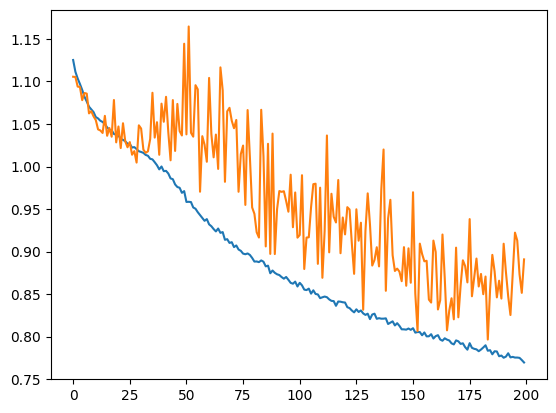

In [9]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [7]:
model.load_state_dict(best_weights)
torch.save(model.state_dict(), 'sis_autoencoder.pt')